In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/tammerkamel/dev/proj/Streambatch/src/Streambatch/"))
from module1 import StreambatchConnection

In [54]:
point = [3.940705,49.345238] # longitude, latitude

# Connect to the Streambatch API
api_key = open('key.txt').read().strip()
connection = StreambatchConnection(api_key=api_key, use_test_api=True)

# request an NDVI time for the point
query_id1 = connection.request_ndvi(     aggregation='mean', points=[point], sources=['ndvi.streambatch_v2','ndvi.sentinel2','ndvi.landsat'])
query_id2 = connection.request_ndvi(     aggregation='mean', points=[point], sources=['ndvi.savgol'])

Using test API
Query ID: 5205dd6b-7071-4096-ac16-0c2f6b0a971f
Number of points: 1
Start date: 2013-01-01
End date: 2023-09-02
Aggregation: mean
Query ID: 9677c6ab-3365-419d-8ae5-6ea05e5a432b
Number of points: 1
Start date: 2013-01-01
End date: 2023-09-02
Aggregation: mean


In [59]:
# get_data() will block until the data is ready
df_new = connection.get_data(query_id1)
df_savgol = connection.get_data(query_id2)
# df_new.tail()

In [60]:
df_s2 = df_new.copy()
# keep only columns time ndvi.sentinel2 and qa.sentinel2
df_s2 = df_s2[['time','ndvi.sentinel2','qa.sentinel2']]
# keep only columns where qa.sentinel2 is 1
df_s2 = df_s2[df_s2['qa.sentinel2']==1]
# remove any row where ndvi.sentinel2 is the same the previous row
df_s2 = df_s2[df_s2['ndvi.sentinel2']!=df_s2['ndvi.sentinel2'].shift()]

In [61]:
df_l8 = df_new.copy()
# keep only columns time ndvi.landsat and qa.landsat
df_l8 = df_l8[['time','ndvi.landsat','qa.landsat']]
# keep only columns where qa.landsat is 1
df_l8 = df_l8[df_l8['qa.landsat']==1]
# remove any row where ndvi.landsat is the same the previous row
df_l8 = df_l8[df_l8['ndvi.landsat']!=df_l8['ndvi.landsat'].shift()]

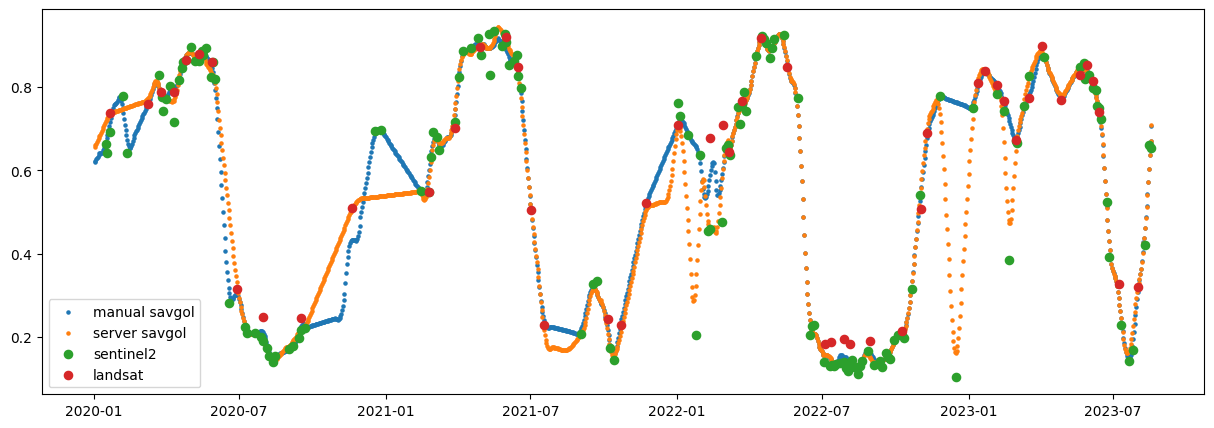

In [63]:
import matplotlib.pyplot as plt

df = df_savgol.copy()
# merge in df_new column ndvi.streambatch on time
df = df.merge(df_new[['time','ndvi.streambatch']], on='time', how='left')


# 2020 onwards
df = df[df['time'] > '2020-01-01']
df_s2 = df_s2[df_s2['time'] > '2020-01-01']
df_l8 = df_l8[df_l8['time'] > '2020-01-01']

# df['v2'] = df_new['ndvi.streambatch']
# df['error'] = df['v2'] - df['ndvi']

# plot time vs ndvi
plt.figure(figsize=(15,5))
plt.scatter(df['time'], df['ndvi'], label='manual savgol',s=5)
plt.scatter(df['time'], df['ndvi.streambatch'], label='server savgol',s=5)
plt.scatter(df_s2['time'], df_s2['ndvi.sentinel2'], label='sentinel2',s=35)
plt.scatter(df_l8['time'], df_l8['ndvi.landsat'], label='landsat',s=35)
plt.legend()
plt.show()
